# Image Interpolation

This tutorial shows how to interpolate PIL Image objects in t-prompts for multi-modal applications.

When you include images in your prompts, they cannot be rendered to plain text. Instead, you access them directly through the prompt structure or via IntermediateRepresentation.

In [1]:
from PIL import Image

from t_prompts import ImageInterpolation, ImageRenderError, dedent, prompt

## Creating a Simple Image

Let's start by creating a simple colored image for demonstration.

Created image: (100, 100) pixels, mode: RGB


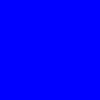

In [2]:
# Create a simple blue square
img = Image.new('RGB', (100, 100), color='blue')

print(f"Created image: {img.size} pixels, mode: {img.mode}")
img

## Creating a Prompt with an Image

Interpolate PIL Image objects just like any other value.

In [3]:
# Create a prompt with an image interpolation
instructions = "Describe what you see in this image"
p = prompt(t"{instructions:inst}\nImage: {img:image}")

print(f"Prompt has {len(list(p.keys()))} interpolations")
print(f"Keys: {list(p.keys())}")

Prompt has 2 interpolations
Keys: ['inst', 'image']


## Accessing the Image

Access the image through the prompt structure using the key.

Node type: ImageInterpolation
Is ImageInterpolation: True

Image size: (100, 100)
Image mode: RGB


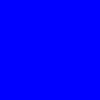

In [4]:
# Access the image interpolation node
image_node = p['image']

print(f"Node type: {type(image_node).__name__}")
print(f"Is ImageInterpolation: {isinstance(image_node, ImageInterpolation)}")

# Access the image value
retrieved_img = image_node.value
print(f"\nImage size: {retrieved_img.size}")
print(f"Image mode: {retrieved_img.mode}")

# Display the retrieved image
retrieved_img

## Rendering to Text Raises an Error

Attempting to render a prompt containing images to text will raise an `ImageRenderError`.

In [5]:
# Try to render to text
try:
    rendered = str(p)
    print(f"Unexpected success: {rendered}")
except ImageRenderError as e:
    print("Expected ImageRenderError:")
    print(f"  {str(e)}")

Unexpected success: Describe what you see in this image
Image: [Image: Unknown 100x100 RGB]


## Provenance and Metadata

Image interpolations preserve full provenance information.

In [6]:
# Access metadata
print("Metadata for image interpolation:")
print(f"  Expression: {image_node.expression}")
print(f"  Key: {image_node.key}")
print(f"  Format spec: {image_node.format_spec}")
print(f"  Index: {image_node.index}")
print(f"  Parent: {image_node.parent}")

Metadata for image interpolation:
  Expression: img
  Key: image
  Format spec: image
  Index: 3
  Parent: Describe what you see in this image
Image: [Image: Unknown 100x100 RGB]


## Using IntermediateRepresentation with Images

The IR provides a text placeholder for images when you need to inspect the structure.

In [7]:
# Get the IntermediateRepresentation
ir = p.ir()

# The IR includes ImageChunk objects
print(f"IR has {len(ir.chunks)} chunks:\n")
for i, chunk in enumerate(ir.chunks):
    chunk_type = type(chunk).__name__
    if chunk_type == 'TextChunk':
        print(f"  {i}. TextChunk: {chunk.text!r}")
    else:
        print(f"  {i}. ImageChunk: {chunk.text}")

# The text property provides a placeholder
print(f"\nIR text representation:\n{ir.text}")

IR has 3 chunks:

  0. TextChunk: 'Describe what you see in this image'
  1. TextChunk: '\nImage: '
  2. ImageChunk: [Image: Unknown 100x100 RGB]

IR text representation:
Describe what you see in this image
Image: [Image: Unknown 100x100 RGB]


## Mixed Content Prompts

You can freely mix text and images in your prompts.

In [8]:
# Create multiple images
img_red = Image.new('RGB', (100, 100), color='red')
img_green = Image.new('RGB', (100, 100), color='green')

context = "Color comparison task"

p_mixed = dedent(t"""
    Context: {context:ctx}

    Compare these two colors:
    Color A: {img_red:color_a}
    Color B: {img_green:color_b}

    Provide a detailed comparison.
    """)

# Inspect the interpolations
print(f"Total interpolations: {len(list(p_mixed.keys()))}\n")
for key in p_mixed.keys():
    node = p_mixed[key]
    if isinstance(node, ImageInterpolation):
        print(f"  {key}: Image ({node.value.size})")
    else:
        print(f"  {key}: Text")

Total interpolations: 3

  ctx: Text
  color_a: Image ((100, 100))
  color_b: Image ((100, 100))


## Practical Use Case: Multi-Modal LLM API

Here's how you might use image interpolation with a multi-modal LLM API.

In [9]:
def prepare_multimodal_message(p):
    """Convert a StructuredPrompt to a multi-modal API format.

    This demonstrates how you might extract text and images
    for a typical vision API that expects separate content blocks.
    """
    content_blocks = []

    # Get the IR to access chunks in order
    ir = p.ir()

    for chunk in ir.chunks:
        chunk_type = type(chunk).__name__
        if chunk_type == 'TextChunk':
            content_blocks.append({
                'type': 'text',
                'text': chunk.text
            })
        elif chunk_type == 'ImageChunk':
            content_blocks.append({
                'type': 'image',
                'image': chunk.image,  # PIL Image object
                'element_id': chunk.element_id
            })

    return content_blocks

# Example usage
system_msg = "You are a helpful assistant that analyzes images."
task = "What color is this square?"

p_api = dedent(t"""
    {system_msg:system}

    Task: {task:task}

    Image to analyze:
    {img:target_image}
    """)

# Convert to API format
content = prepare_multimodal_message(p_api)

print("Content blocks for API:")
for i, block in enumerate(content):
    if block['type'] == 'text':
        text_preview = block['text'][:50] + '...' if len(block['text']) > 50 else block['text']
        print(f"  {i}. Text: {text_preview!r}")
    else:
        print(f"  {i}. Image: {block['image'].size}")

Content blocks for API:
  0. Text: 'You are a helpful assistant that analyzes images.'
  1. Text: '\n\nTask: '
  2. Text: 'What color is this square?'
  3. Text: '\n\nImage to analyze:\n'
  4. Image: (100, 100)


## Working with Real Images

Let's load a real image file and use it in a prompt.

In [10]:
# Try to load an image from the assets folder
import os

asset_path = "../assets/warps-and-wefts.png"
if os.path.exists(asset_path):
    real_img = Image.open(asset_path)
    print(f"Loaded image: {real_img.size} pixels, mode: {real_img.mode}")

    # Create a prompt with the real image
    analysis_prompt = dedent(t"""
        Analyze this textile pattern:

        {real_img:pattern}

        Describe:
        1. The weave structure
        2. Color palette
        3. Overall aesthetic
        """)

    # Access the image
    pattern_node = analysis_prompt['pattern']
    print(f"\nImage in prompt: {pattern_node.value.size}")

    # Display
    pattern_node.value
else:
    print(f"Image file not found at {asset_path}")
    print("Using the blue square from earlier instead.")
    real_img = img

Loaded image: (536, 536) pixels, mode: RGB

Image in prompt: (536, 536)


## Summary

Image interpolation enables multi-modal prompts:

✅ **Installation** - Requires `pip install t-prompts[image]` (PIL/Pillow)  
✅ **Interpolation** - Interpolate PIL Image objects like any value  
✅ **Access** - Use `p['key'].value` to retrieve images  
✅ **No text rendering** - `str(p)` raises `ImageRenderError`  
✅ **IR support** - Images become `ImageChunk` objects with text placeholders  
✅ **Type checking** - Use `isinstance(node, ImageInterpolation)`  
✅ **Provenance** - Full metadata preserved (expression, key, format_spec)  
✅ **Mixed content** - Freely mix text and images  

**Key Pattern:**
```python
# Create prompt with image
img = Image.open('photo.jpg')
p = prompt(t"Describe: {img:photo}")

# Access image
image_obj = p['photo'].value

# Check if node is an image
if isinstance(p['photo'], ImageInterpolation):
    print("It's an image!")
```